# Generate Contour Stimuli (similiar to Field et al., 1993)
- mean luminance = 35 cd/m2
- images 512x512 pixels
- linearized lookup table
- **elements**: gabors (linear grating times circular gaussian), sd = 4.0 pixels, period=8.0 pixels. At viewing distance 90cm, these parameters resulted in elements with a peak spatial frequency of 8.0 c/deg and a bandwidth of approx. 1.2 octaves (cr = & deg). ** UPDATE for modern screen resolutions. 1.0 deg = 64 pixels.
- **paths**:


# Imports

In [1]:
import sys
# sys.path.insert(1,'../')

# Import python library for this notebook
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function
import math
import torch
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.html.widgets import interact, interactive, fixed
from IPython.display import display 
from tqdm.notebook import tqdm
import os
import seaborn as sns

# show figures inline
%matplotlib inline

# Extra imports
from field_stim_functions import *

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Hyperparameters

In [2]:
## Gabor hyperparameters
# Gabor2D(lambda_=8, theta=0, phase=-90, stdev=5, imSize=(60,60), elCentre=None, gratingContrast=1.0)

### Displaying a black square on the screen using the image size set above

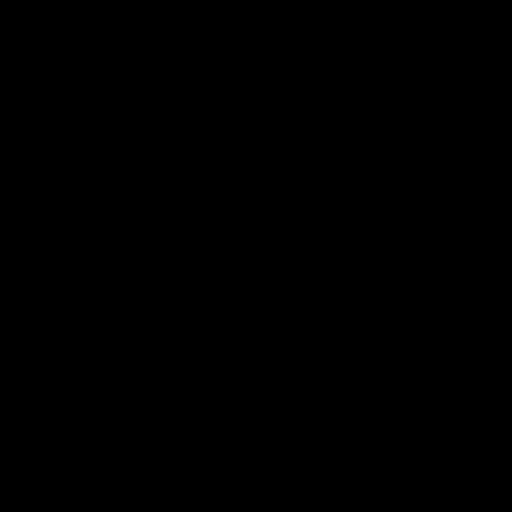

In [3]:
## This is height,width / rows,col
imSize=(512,512)
img_array=(np.ones((imSize[0],imSize[1]))*0).astype(np.uint8)
img_array.shape
Image.fromarray(img_array)

In [4]:
img_contour,img_control,img_contour_background,img_control_background,points,centers,grid,image_recorder_dict= generate_everything(alpha_offset=90-0,B=30)

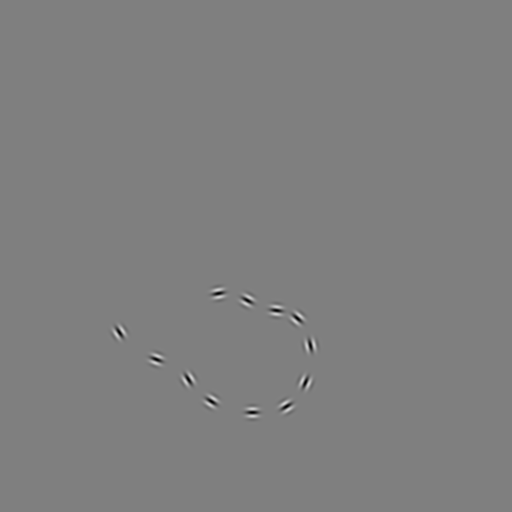

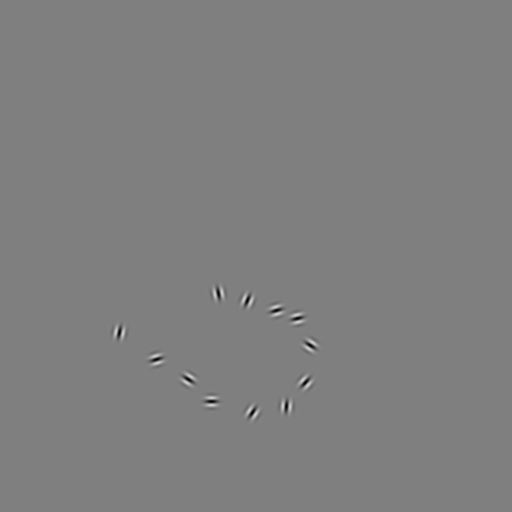

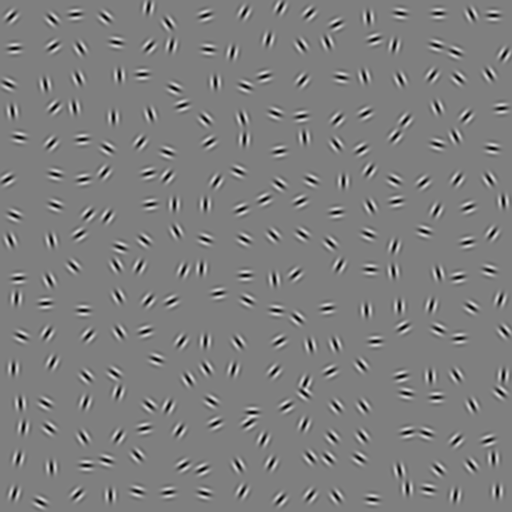

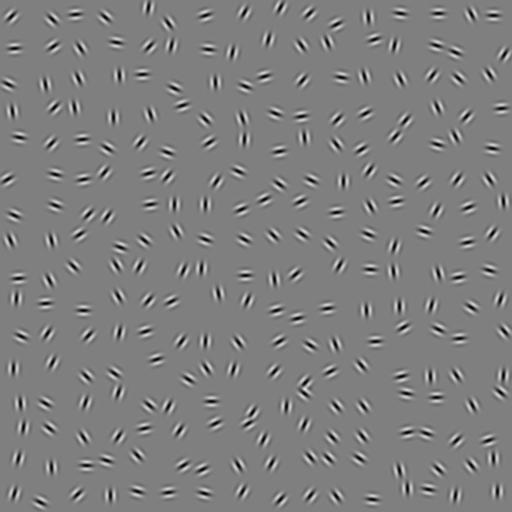

In [5]:
display(img_contour)
display(img_control)
display(img_contour_background)
display(img_control_background)

## Testing AF compuations

### a) Getting difference values

In [6]:

# Sample 16x16 array
arr = np.random.rand(16, 16)

# Reshaping for broadcasting
arr_reshaped = arr[:, :, np.newaxis, np.newaxis]
arr_broadcasted = arr[np.newaxis, np.newaxis, :, :]

# Calculating the difference using broadcasting
diff = np.abs(arr_reshaped - arr_broadcasted)

print(diff.shape)  # Outputs: (16, 16, 16, 16)

(16, 16, 16, 16)


In [7]:
diff[1][1][1][1]

0.0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

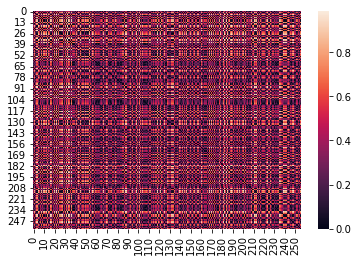

In [8]:
sns.heatmap(np.reshape(diff,(256,256)))
np.diagonal(np.reshape(diff,(256,256)))

### b) Getting distances

In [9]:
# Generate the row and column indices
rows, cols = np.indices((16, 16))

# Reshape the indices to use broadcasting
rows_reshaped = rows[:, :, np.newaxis, np.newaxis]
cols_reshaped = cols[:, :, np.newaxis, np.newaxis]

# Compute the squared differences
diff_rows = (rows_reshaped - rows) ** 2
diff_cols = (cols_reshaped - cols) ** 2

# Compute the euclidean distances for each unit against all others
distance_map = np.sqrt(diff_rows + diff_cols)

In [10]:
@interact(row=(1,16),col=(1,16))
def g(row=1,col=1):
    sns.heatmap(distance_map[row-1][col-1])

interactive(children=(IntSlider(value=1, description='row', max=16, min=1), IntSlider(value=1, description='co…

### C) Combining the 2

In [11]:
diff.shape

(16, 16, 16, 16)

In [12]:
distance_map.shape

(16, 16, 16, 16)

In [13]:
distance_map=distance_map+1e-4

In [14]:
af_mask=np.sum((diff/distance_map),axis=(2,3))

<AxesSubplot:>

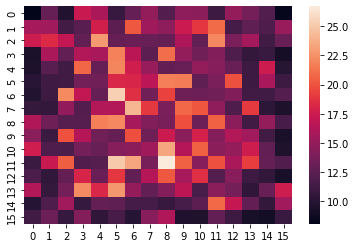

In [15]:
sns.heatmap(af_mask)

### D) Representing angles

In [16]:
print(image_recorder_dict.keys())

print(image_recorder_dict['grid'].shape)
print(image_recorder_dict['element_position'].shape)
print(image_recorder_dict['element_theta_contour'].shape)
print(image_recorder_dict['element_theta_control'].shape)

# For the background element
print(np.all(image_recorder_dict['element_theta_contour'][np.where(image_recorder_dict['grid']==0)] == image_recorder_dict['element_theta_control'][np.where(image_recorder_dict['grid']==0)]))

# For the path element
print(np.all(image_recorder_dict['element_theta_contour'][np.where(image_recorder_dict['grid']==1)] == image_recorder_dict['element_theta_control'][np.where(image_recorder_dict['grid']==1)]))

dict_keys(['image_width', 'image_height', 'path_B', 'path_D', 'path_A', 'path_numElement', 'path_jitterB', 'path_jitterD', 'path_startRadius', 'path_offset', 'grid', 'path_points', 'path_centers', 'element_position', 'element_theta_contour', 'element_theta_control', 'gabor_lambda', 'gabor_phase', 'gabor_stdev', 'gabor_imSize', 'gabor_elCentre', 'gabor_gratingContrast'])
(16, 16)
(16, 16, 2)
(16, 16, 1)
(16, 16, 1)
True
False


<AxesSubplot:ylabel='Density'>

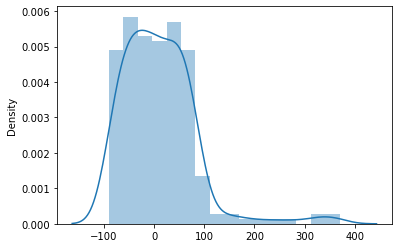

In [17]:
sns.distplot(image_recorder_dict['element_theta_contour'])

#### Normalzing everything between 0 and 360 degrees

In [18]:
normalized_angles_deg = image_recorder_dict['element_theta_contour'] % 360

<AxesSubplot:ylabel='Density'>

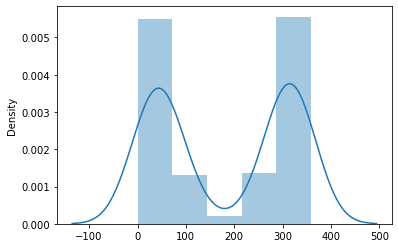

In [19]:
sns.distplot(normalized_angles_deg)

#### Normalzing everything as lying on a unit circle

In [20]:
print(image_recorder_dict.keys())

print(image_recorder_dict['grid'].shape)
print(image_recorder_dict['element_position'].shape)
print(image_recorder_dict['element_theta_contour'].shape)
print(image_recorder_dict['element_theta_control'].shape)

# For the background element
print(np.all(image_recorder_dict['element_theta_contour'][np.where(image_recorder_dict['grid']==0)] == image_recorder_dict['element_theta_control'][np.where(image_recorder_dict['grid']==0)]))

# For the path element
print(np.all(image_recorder_dict['element_theta_contour'][np.where(image_recorder_dict['grid']==1)] == image_recorder_dict['element_theta_control'][np.where(image_recorder_dict['grid']==1)]))

dict_keys(['image_width', 'image_height', 'path_B', 'path_D', 'path_A', 'path_numElement', 'path_jitterB', 'path_jitterD', 'path_startRadius', 'path_offset', 'grid', 'path_points', 'path_centers', 'element_position', 'element_theta_contour', 'element_theta_control', 'gabor_lambda', 'gabor_phase', 'gabor_stdev', 'gabor_imSize', 'gabor_elCentre', 'gabor_gratingContrast'])
(16, 16)
(16, 16, 2)
(16, 16, 1)
(16, 16, 1)
True
False


<AxesSubplot:ylabel='Density'>

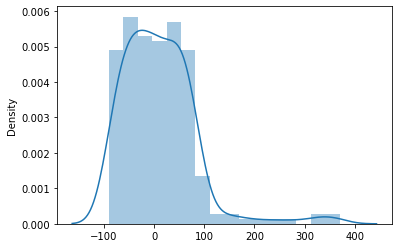

In [21]:
sns.distplot(image_recorder_dict['element_theta_contour'])

In [22]:
angles_deg = np.array([0, 45, 90, 360, 405, -45, -360, -405])
angles_rad = np.deg2rad(angles_deg)

# Convert angles to points on the unit circle in the complex plane
complex_representation = np.exp(1j * angles_rad)

print(complex_representation)

[1.00000000e+00+0.00000000e+00j 7.07106781e-01+7.07106781e-01j
 6.12323400e-17+1.00000000e+00j 1.00000000e+00-2.44929360e-16j
 7.07106781e-01+7.07106781e-01j 7.07106781e-01-7.07106781e-01j
 1.00000000e+00+2.44929360e-16j 7.07106781e-01-7.07106781e-01j]


In [23]:
complex_representation[3]

(1-2.4492935982947064e-16j)

In [24]:
complex_representation[0]

(1+0j)

In [25]:
def angle_difference(complex1, complex2):
    dot_product = np.real(complex1 * np.conj(complex2))  # Compute the dot product
    angle_rad = np.arccos(dot_product)  # Compute the angle in radians
    angle_deg = np.degrees(angle_rad)  # Convert the angle to degrees
    return angle_deg

# For example:
complex1 = np.exp(1j * np.radians(45))
complex2 = np.exp(1j * np.radians(90))
diff = angle_difference(complex1, complex2)
print(diff)

45.00000000000001


### This is a bit tricky because it a 2 dimensional complex representation, lets try converting it to a one dimensional representation

In [26]:
def get_diff_map(arr):
    # Reshaping for broadcasting
    arr_reshaped = arr[:, :, np.newaxis, np.newaxis]
    arr_broadcasted = arr[np.newaxis, np.newaxis, :, :]

    # Calculating the difference using broadcasting
    diff_map = np.abs(arr_reshaped - arr_broadcasted)

    return diff_map

In [27]:
get_diff_map(np.squeeze(image_recorder_dict['element_theta_contour'])).shape

(16, 16, 16, 16)

In [28]:
def cyclic_get_diff_map(arr):
    
    ## Convert the array in radians
    arr= arr * np.pi / 180
    
    # Reshaping for broadcasting
    arr_reshaped = arr[:, :, np.newaxis, np.newaxis]
    arr_broadcasted = arr[np.newaxis, np.newaxis, :, :]

    # Calculating the difference using broadcasting
    diff_map = np.abs(arr_reshaped - arr_broadcasted) % (2 * np.pi)
    
    ## Accounting for cyclicity
    mask = diff_map > np.pi
    diff_map[mask] = 2 * np.pi - diff_map[mask]

    return diff_map

In [29]:
cyclic_get_diff_map(np.squeeze(image_recorder_dict['element_theta_contour'])).shape

(16, 16, 16, 16)

### D) Combining all

In [30]:
def get_diff_map(arr):
    # Reshaping for broadcasting
    arr_reshaped = arr[:, :, np.newaxis, np.newaxis]
    arr_broadcasted = arr[np.newaxis, np.newaxis, :, :]

    # Calculating the difference using broadcasting
    diff_map = np.abs(arr_reshaped - arr_broadcasted)

    return diff_map

In [31]:
def cyclic_get_diff_map(arr):
    
    ## Convert the array in radians
    arr= arr * np.pi / 180
    
    # Reshaping for broadcasting
    arr_reshaped = arr[:, :, np.newaxis, np.newaxis]
    arr_broadcasted = arr[np.newaxis, np.newaxis, :, :]

    # Calculating the difference using broadcasting
    diff_map = np.abs(arr_reshaped - arr_broadcasted) % (2 * np.pi)
    
    ## Accounting for cyclicity
    mask = diff_map > np.pi
    diff_map[mask] = 2 * np.pi - diff_map[mask]

    return diff_map

In [32]:
def get_distance_map(arr):

    # Generate the row and column indices
    rows, cols = np.indices((arr.shape[0], arr.shape[1]))

    # Reshape the indices to use broadcasting
    rows_reshaped = rows[:, :, np.newaxis, np.newaxis]
    cols_reshaped = cols[:, :, np.newaxis, np.newaxis]

    # Compute the squared differences
    diff_rows = (rows_reshaped - rows) ** 2
    diff_cols = (cols_reshaped - cols) ** 2

    # Compute the euclidean distances for each unit against all others
    distance_map = np.sqrt(diff_rows + diff_cols)
    
    return distance_map

In [33]:
def get_af_map(arr):
    diff_map=get_diff_map(arr)
    
    distance_map=get_distance_map(arr)
    distance_map=distance_map+1e-4
    
    
    ## NEED HELP DEFINING THIS CONSTRAINT
    af_map=np.sum((diff_map*distance_map),axis=(2,3))
    
    ## This is what we would need ideally right?
    # af_map=np.sum(-1.0 * (diff_map*distance_map),axis=(2,3))
    
    
    return af_map

In [34]:
def get_af_2_attention(arr,imsize=512):
    
    new_arr=np.repeat(np.repeat(arr,imsize/arr.shape[0],axis=0),imsize/arr.shape[1],axis=1)    
    attention_map=(new_arr - np.min(new_arr)) / (np.max(new_arr) - np.min(new_arr))
    

    
    return attention_map

# Testing the AF model

In [35]:
img_contour,img_control,img_contour_background,img_control_background,points,centers,grid,image_recorder_dict= generate_everything(alpha_offset=90-0,B=30)




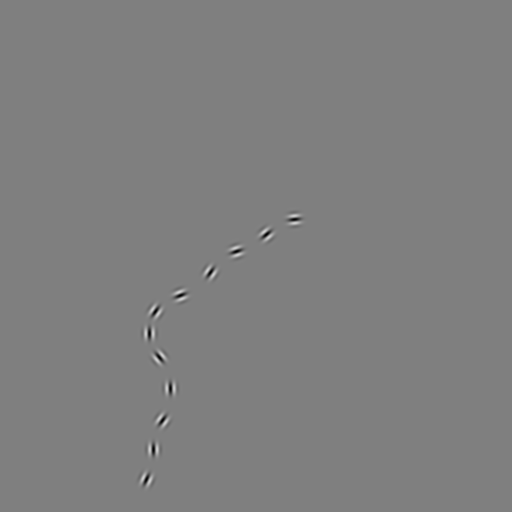

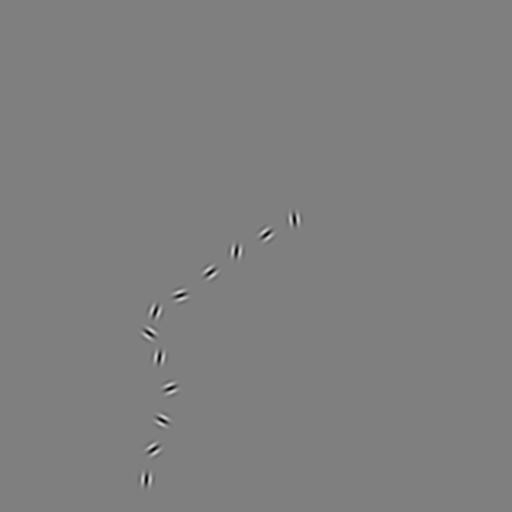

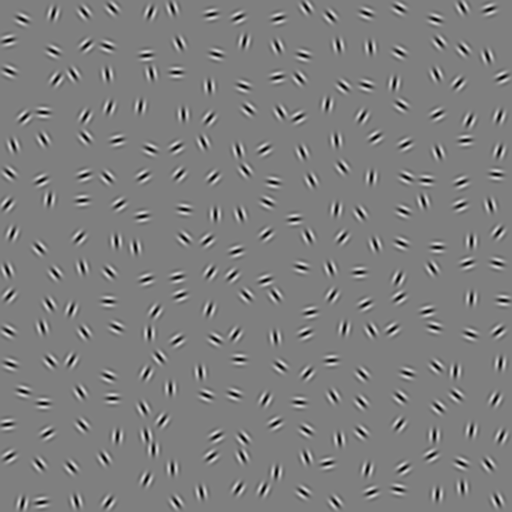

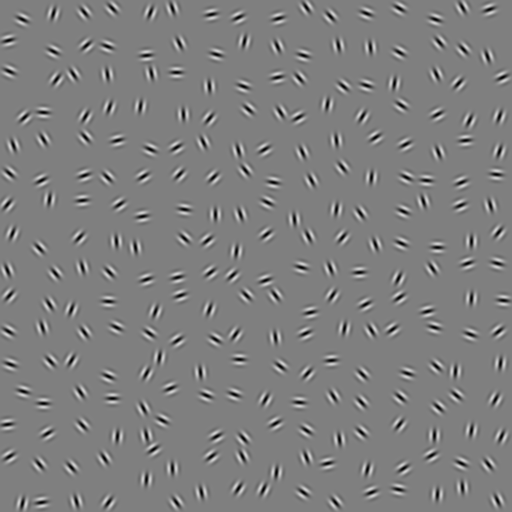

In [36]:
display(img_contour)
display(img_control)
display(img_contour_background)
display(img_control_background)

In [37]:
print(image_recorder_dict.keys())

print(image_recorder_dict['grid'].shape)
print(image_recorder_dict['element_position'].shape)
print(image_recorder_dict['element_theta_contour'].shape)
print(image_recorder_dict['element_theta_control'].shape)

# For the background element
print(np.all(image_recorder_dict['element_theta_contour'][np.where(image_recorder_dict['grid']==0)] == image_recorder_dict['element_theta_control'][np.where(image_recorder_dict['grid']==0)]))

# For the path element
print(np.all(image_recorder_dict['element_theta_contour'][np.where(image_recorder_dict['grid']==1)] == image_recorder_dict['element_theta_control'][np.where(image_recorder_dict['grid']==1)]))

dict_keys(['image_width', 'image_height', 'path_B', 'path_D', 'path_A', 'path_numElement', 'path_jitterB', 'path_jitterD', 'path_startRadius', 'path_offset', 'grid', 'path_points', 'path_centers', 'element_position', 'element_theta_contour', 'element_theta_control', 'gabor_lambda', 'gabor_phase', 'gabor_stdev', 'gabor_imSize', 'gabor_elCentre', 'gabor_gratingContrast'])
(16, 16)
(16, 16, 2)
(16, 16, 1)
(16, 16, 1)
True
False


In [38]:
af_map=get_af_map(np.squeeze(image_recorder_dict['element_theta_contour']))

<AxesSubplot:>

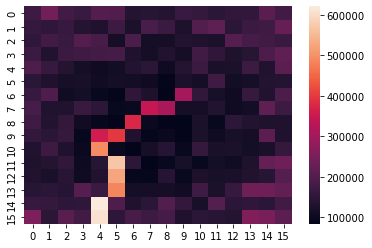

In [39]:
sns.heatmap(af_map)

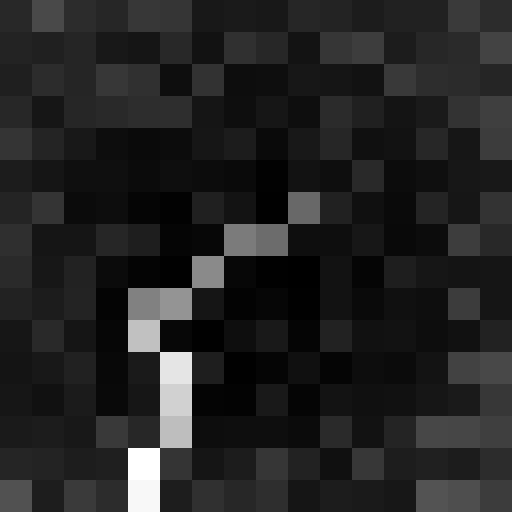

In [40]:
Image.fromarray((get_af_2_attention(af_map) * 255).astype(np.uint8))

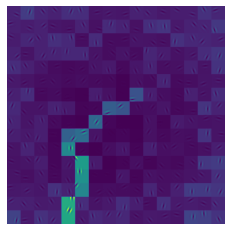

In [41]:
threshold=0.0
output_attention=threshold* np.array(img_contour_background) + ((1-threshold)*(np.array(img_contour_background) * get_af_2_attention(af_map)))

plt.imshow(output_attention)
plt.axis('off')
plt.show()

In [42]:
@interact(threshold=(0.0,1.0))
def g(threshold=1.0):
    output_attention=threshold* np.array(img_contour_background) + ((1-threshold)*(np.array(img_contour_background) * get_af_2_attention(af_map)))
    
    plt.figure(figsize=(8,8))
    plt.imshow(output_attention)
    plt.axis('off')
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='threshold', max=1.0), Output()), _dom_classes=('widg…

#### Control

In [43]:
af_map=get_af_map(np.squeeze(image_recorder_dict['element_theta_control']))

<AxesSubplot:>

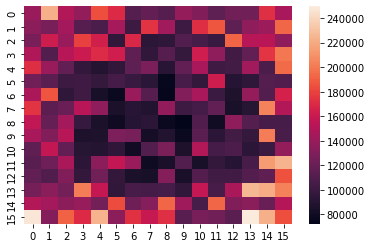

In [44]:
sns.heatmap(af_map)

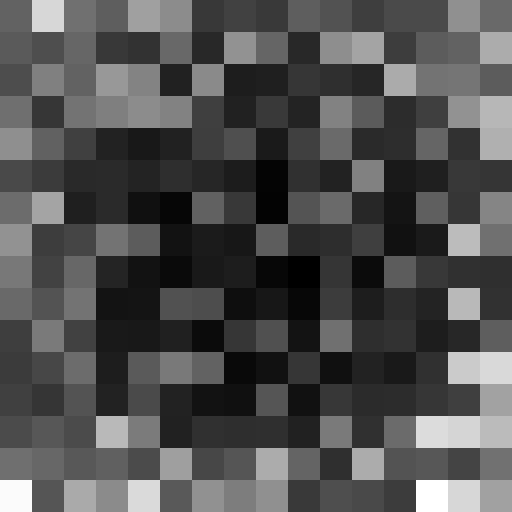

In [45]:
Image.fromarray((get_af_2_attention(af_map) * 255).astype(np.uint8))

In [46]:
output_attention=np.array(img_contour_background) * get_af_2_attention(af_map)

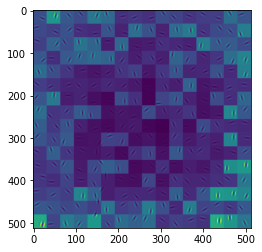

In [47]:
plt.imshow(output_attention)